# Loading Data

In [1]:
# Load modules:
import numpy as np
import pandas as pd
from pprint import pprint as pp
import matplotlib.pyplot as plt

# Load "Asheville-listings.csv":
listings_df = pd.read_csv("datasets/Asheville/Asheville-listings.csv")

# Drop unwanted columns:
cols_i_dont_care = ['calculated_host_listings_count', 'calendar_last_scraped', 'calendar_updated', 
                    'country', 'country_code', 'description', 'has_availability', 'host_about', 
                    'host_has_profile_pic', 'host_id', 'host_location', 
                    'host_name', 'host_neighbourhood', 'host_picture_url', 
                    'host_response_time', 'host_thumbnail_url', 'host_url', 
                    'jurisdiction_names', 'last_scraped', 'last_searched', 
                    'license', 'listing_url', 'market', 'medium_url', 
                    'name', 'neighborhood_overview', 'neighbourhood_cleansed', 
                    'notes', 'picture_url', 'region_id', 'region_name', 
                    'region_parent_id', 'scrape_id', 'smart_location', 'space', 
                    'state', 'street', 'summary', 'thumbnail_url', 'transit', 
                    'xl_picture_url', 'zipcode', 'experiences_offered',
                    'square_feet', 'neighbourhood', 'host_verifications']
listings_df.drop(cols_i_dont_care, axis=1, inplace=True)

# Preview:
listings_df.head()
pp(list(listings_df.columns))

['id',
 'host_since',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_listings_count',
 'host_total_listings_count',
 'host_identity_verified',
 'city',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'price',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'requires_license',
 'instant_bookable',
 'cancellation_policy',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'reviews_per_month']


# Data Cleaning

## Trying to turn list of amenities into 0-1 vectors 

We gonna work on this column:

In [2]:
amenities_col = listings_df['amenities']
amenities_col.head()

0    {"Wireless Internet","Air Conditioning",Kitche...
1    {TV,"Cable TV",Internet,"Wireless Internet","A...
2    {TV,"Wireless Internet","Air Conditioning",Kit...
3    {Internet,"Wireless Internet","Air Conditionin...
4    {Internet,"Wireless Internet","Free Parking on...
Name: amenities, dtype: object

### Using the CountVectorizer

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern = ur'(?!,|$)(.+?)(?=,|$)')

# first, get rid of all the '"'s:
amenities_col = amenities_col.str.replace('"', '')
amenities_col.head()

# Now actually transform the data:
X = vectorizer.fit_transform(amenities_col)
labels = vectorizer.get_feature_names()

# The inverse should work:
# vectorizer.inverse_transform(X)[:3]

Data in this sparse matrix look like:

In [4]:
vectors = X.todense()
vectors

matrix([[0, 0, 1, ..., 0, 1, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ..., 
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]])

In [5]:
listings_df.drop('amenities', axis=1, inplace=True)

vectors_df = pd.DataFrame(vectors, columns = ['AMN_'+label for label in labels])

listings_AMN_df = pd.concat([listings_df, vectors_df], axis=1)

# listings_AMN_df.to_csv('datasets/Asheville/Asheville-listings-with-amenities.csv')

listings_AMN_df.head()

,id,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,city,latitude,...,AMN_wheelchair accessible,AMN_wireless internet,AMN_{air conditioning,AMN_{cable tv,AMN_{internet,AMN_{kitchen,AMN_{tv,AMN_{wheelchair accessible,AMN_{wireless internet,AMN_{}
0,665257,2012-06-10,100%,NaN,f,1,1,t,Asheville,35.590784,...,0,0,0,0,0,0,0,0,1,0
1,2746729,2012-12-01,100%,84%,t,5,5,t,Asheville,35.584968,...,0,1,0,0,0,0,1,0,0,0
2,6919450,2015-06-19,NaN,NaN,f,1,1,f,Asheville,35.626600,...,0,1,0,0,0,0,1,0,0,0
3,12286328,2011-06-26,100%,68%,f,6,6,f,Asheville,35.579159,...,0,1,0,0,1,0,0,0,0,0
4,156926,2011-06-26,100%,68%,f,6,6,f,Asheville,35.577755,...,0,1,0,0,1,0,0,0,0,0


## Typed Features

First of all:

In [6]:
listings_latest_df = listings_AMN_df

For columns whose possible values are really comparable, we can convert them into a scale:

In [7]:
def convertComparableFeatureToNumerical(df, col_name, expected_types, assigned_values):
    possible_types = df[col_name].unique().tolist()
    #print possible_types
    assert set(expected_types).issuperset(set(possible_types))
    converter = dict(zip(possible_types, assigned_values)) 
    pp(converter)
    return df.replace({col_name: converter})

In [8]:
listings_latest_df = convertComparableFeatureToNumerical(listings_latest_df, 'cancellation_policy', 
                                   expected_types  = ['moderate', 'strict', 'flexible', 'super_strict_30', 'super_strict_60'],
                                   assigned_values = [2, 3, 1, 4])


listings_latest_df = convertComparableFeatureToNumerical(listings_latest_df, 'room_type', 
                                   expected_types  = ['Entire home/apt', 'Private room', 'Shared room'],
                                   assigned_values = [3, 2, 1])

listings_latest_df = convertComparableFeatureToNumerical(listings_latest_df, 'bed_type', 
                                   expected_types  = ['Real Bed', 'Airbed', 'Futon', 'Pull-out Sofa', 'Couch'],
                                   assigned_values = [5,1,4,3,2])

{'flexible': 1, 'moderate': 2, 'strict': 3, 'super_strict_30': 4}
{'Entire home/apt': 3, 'Private room': 2, 'Shared room': 1}
{'Airbed': 1, 'Couch': 2, 'Futon': 4, 'Pull-out Sofa': 3, 'Real Bed': 5}


For those not really so, we have to expand those columns:

In [9]:
from sklearn.preprocessing import LabelBinarizer

#col_name           = 'bed_type' # configure this!
#binarizer          = LabelBinarizer()
#try:
#   X              = binarizer.fit_transform(listings_latest_df[col_name])
#except KeyError:
#    print 'Error: Column already expanded. Skipping.'
#else:
#    col_labels         = ['BED='+i for i in binarizer.classes_]
#    X_df               = pd.DataFrame(X, columns=col_labels)
#    listings_latest_df.drop(col_name, axis=1, inplace=True) # drop the old column, by name
#    listings_latest_df = pd.concat([listings_latest_df, X_df], axis=1) # attach the expanded features
#    print 'Expanded', col_name, 'into', col_labels,'.'

#Funny that listings providing something other than real beds are soooo rare:
#X_df[X_df['BED=Real Bed']==0]

col_name           = 'property_type' # configure this!
binarizer          = LabelBinarizer()
try:
    X              = binarizer.fit_transform(listings_latest_df[col_name])
except KeyError:
    print 'Error: Column already expanded. Skipping.'
else:
    col_labels         = ['POPTY='+i for i in binarizer.classes_]
    X_df               = pd.DataFrame(X, columns=col_labels)
    listings_latest_df.drop(col_name, axis=1, inplace=True) # drop the old column, by name
    listings_latest_df = pd.concat([listings_latest_df, X_df], axis=1) # attach the expanded features
    print 'Expanded', col_name, 'into', col_labels,'.'

Expanded property_type into ['POPTY=Apartment', 'POPTY=Bed & Breakfast', 'POPTY=Bungalow', 'POPTY=Cabin', 'POPTY=Camper/RV', 'POPTY=Chalet', 'POPTY=Condominium', 'POPTY=Dorm', 'POPTY=Earth House', 'POPTY=House', 'POPTY=Loft', 'POPTY=Other', 'POPTY=Tent', 'POPTY=Townhouse', 'POPTY=Treehouse', 'POPTY=Villa', 'POPTY=Yurt'] .


In [10]:
listings_df = listings_latest_df

# drop listings without a single review:
processed_df = listings_df[listings_df.number_of_reviews != 0] \
            .dropna(subset = ['host_response_rate', 'host_acceptance_rate', 'review_scores_value', 
                              'bathrooms', 'bedrooms', 'beds', 'review_scores_location'])
        # drop listings with no values in these columns:

# ====================    Type conversions    ====================

# Convert columns in currency to floats:
cols_in_currency = [
 'price',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee', 
 'extra_people']
processed_df[cols_in_currency]=(listings_df[cols_in_currency]
                              .replace( '[\$,)]','', regex=True )
                              .replace( '[(]','-',   regex=True ).astype(float).fillna(0))

# Convert columns in percentage to floats:
cols_in_percentage = [
    'host_response_rate',
    'host_acceptance_rate' ]
processed_df[cols_in_percentage]=(listings_df[cols_in_percentage]
                              .replace( '%','', regex=True ).astype(float).fillna(0))

# scale review_scores_rating from 0~100 to 0-10:
processed_df.loc[:, 'review_scores_rating'] = listings_df['review_scores_rating']*.1

# ====================    Type conversions    ====================

processed_df.head()

,id,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,city,latitude,...,POPTY=Dorm,POPTY=Earth House,POPTY=House,POPTY=Loft,POPTY=Other,POPTY=Tent,POPTY=Townhouse,POPTY=Treehouse,POPTY=Villa,POPTY=Yurt
1,2746729,2012-12-01,100.0,84.0,t,5,5,t,Asheville,35.584968,...,0,0,0,0,0,1,0,0,0,0
4,156926,2011-06-26,100.0,68.0,f,6,6,f,Asheville,35.577755,...,0,0,1,0,0,0,0,0,0,0
5,3767793,2013-10-12,100.0,73.0,f,3,3,t,Asheville,35.635953,...,0,0,1,0,0,0,0,0,0,0
6,5927700,2015-02-12,100.0,100.0,f,1,1,t,Asheville,35.589878,...,0,0,1,0,0,0,0,0,0,0
7,6698737,2015-03-19,100.0,96.0,t,1,1,t,Asheville,35.575506,...,0,0,1,0,0,0,0,0,0,0


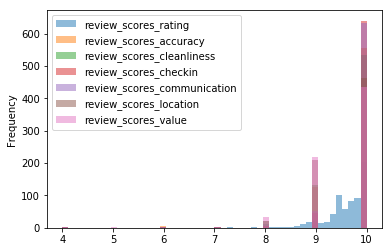

In [11]:
plt.figure()
processed_df[[
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value'
]].plot.hist(alpha =.5, bins=50)
plt.show();

In [12]:
# if no record for 'security_deposit', 'cleaning_fee' is found, assume to be asking for nothing:
processed_df['security_deposit'] = processed_df['security_deposit'].fillna(0)/processed_df.price
processed_df['cleaning_fee'    ] = processed_df['cleaning_fee'    ].fillna(0)/processed_df.price

# convert discounts:
processed_df['monthly_price'] = ((processed_df.price*30-processed_df.monthly_price)/(processed_df.price*30))
processed_df['weekly_price' ] = ((processed_df.price*7 -processed_df.weekly_price )/(processed_df.price*7 ))

# convert prices of each listings to its ratio compared against the average price in its city:
# [TODO] listings_df.price = listings_df.price/
# rename columns:
processed_df.rename(columns={'monthly_price': 'monthly_discount_percentage', 
                             'weekly_price': 'weekly_discount_percentage',
                             'security_deposit': 'security_deposit_ratio_to_price',
                             'cleaning_fee': 'cleaning_fee_ratio_to_price'
                            }, inplace=True)


In [16]:
print "List of Columns and Numbers of Nulls There:"
null_counts = processed_df.isnull().sum()
print null_counts[null_counts>0]
print "Total amount of entries:", len(processed_df)

List of Columns and Numbers of Nulls There:
Series([], dtype: int64)
Total amount of entries: 696


In [14]:
# Convert boolean columns to binary values:
boolean_columns = ['host_is_superhost', 'host_identity_verified', 'is_location_exact', 'requires_license', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']

processed_df.replace({'t': 1, 'f':0}, inplace = True)

In [17]:
cols_in_date = [
    'host_since',
    'first_review',
    'last_review']
airbnb_founded_date = pd.to_datetime('2008-08-01')
for col in cols_in_date:
    processed_df[col] = ((pd.to_datetime(processed_df[col])-airbnb_founded_date) / np.timedelta64(1, 'D')).astype('int')

Save to file:

In [18]:
processed_df.to_csv('datasets/Asheville/Asheville-processed.csv', index=False)